# Travelling Salesman Problem

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## Overview

One of the most famous NP-hard problems in combinatorial optimization, the travelling salesman problem (TSP) considers the following question: "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city?" 

This question can also be formulated in the language of graph theory. Given a weighted undirected complete graph $G = (V,E)$, where each vertex $i \in V$ corresponds to city $i$ and the weight $w_{i,j}$ of each edge $(i,j,w_{i,j}) \in E$ represents the distance between cities $i$ and $j$, the TSP is to find the shortest Hamiltonian cycle in $G$, where a Hamiltonian cycle is a closed loop on a graph in which every vertex is visited exactly once. Note that because $G$ is an undirected graph, weights are symmetric, i.e., $w_{i,j} = w_{j,i}$. 

## Use QNN to solve TSP

To use QNN to solve travelling salesman problem, we need to first encode the classical problem to quantum. 
The encoding consists of two parts:

1. The route how the salesman visits each city is encoded in quantum states -- ${\rm qubit}_{i,t} = |1\rangle$ corresponds to salesman visiting city $i$ at time $t$. 
    1. As an example, if there are two cities $\{A,B\}$, visiting $A$ then $B$ will be in state $|1001\rangle$, as the salesman visits the city $A$ at time $1$ and the city $B$ at time $2$.
    2. Similarly, $|0110\rangle$ means visiting $B$ then $A$.
    3. Note: $|0101\rangle$ means visiting $A$ and $B$ both at time $2$, so it is infeasible. To avoid such states, a penalty function will be used (see the next section for details.)

2. The total distance is encoded in a loss function: 

$$
L(\psi(\vec{\theta})) = \langle\psi(\vec{\theta})|H_C|\psi(\vec{\theta})\rangle,
\tag{1}
$$

where $|\psi(\vec{\theta})\rangle$ is the output state from a parameterized quantum circuit. 

The details about how to encode the classical problem to quantum is given in detail in the next section. 
After optimizing the loss function, we will obtain the optimal quantum state. Then a decoding process will be performed to get the final route.

### Encoding the TSP

To transform the TSP into a problem applicable for parameterized quantum circuits, we need to encode the TSP into a Hamiltonian. 

We realize the encoding by first constructing an integer programming problem. Suppose there are $n=|V|$ vertices in graph $G$. Then for each vertex $i \in V$, we define $n$ binary variables $x_{i,t}$, where $t \in [0,n-1]$, such that

$$
x_{i, t}=
\begin{cases}
1, & \text {if in the resulting Hamiltonian cycle, vertex } i \text { is visited at time } t\\
0, & \text{otherwise}
\end{cases}.
\tag{2}
$$

As there are $n$ vertices, we have $n^2$ variables in total, whose value we denote by a bit string $x=x_{1,1}x_{1,2}\dots x_{n,n}$. Assume for now that the bit string $x$ represents a Hamiltonian cycle. Then for each edge $(i,j,w_{i,j}) \in E$, we will have $x_{i,t} = x_{j,t+1}=1$, i.e., $x_{i,t}\cdot x_{j,t+1}=1$, if and only if the Hamiltonian cycle visits vertex $i$ at time $t$ and vertex $j$ at time $t+1$; otherwise, $x_{i,t}\cdot x_{j,t+1}$ will be $0$. Therefore the length of a Hamiltonian cycle is

$$
D(x) = \sum_{i,j} w_{i,j} \sum_{t} x_{i,t} x_{j,t+1}.
\tag{3}
$$

For $x$ to represent a valid Hamiltonian cycle, the following constraint needs to be met:

$$
\sum_t x_{i,t} = 1 \quad  \forall i \in [0,n-1] \quad \text{ and } \quad \sum_i x_{i,t} = 1 \quad  \forall t \in [0,n-1],
\tag{4}
$$

where the first equation guarantees that each vertex is only visited once and the second guarantees that only one vertex is visited at each time $t$. Then the cost function under the constraint can be formulated below, with $A$ being the penalty parameter set to ensure that the constraint is satisfied:

$$
C(x) = D(x)+ A\left( \sum_{i} \left(1-\sum_t  x_{i,t}\right)^2 +  \sum_{t} \left(1-\sum_i  x_{i,t}\right)^2  \right).
\tag{5}
$$

Note that as we would like to minimize the length $D(x)$ while ensuring $x$ represents a valid Hamiltonian cycle, we had better set $A$ large, at least larger than the largest weight of edges.

We now need to transform the cost function $C(x)$ into a Hamiltonian to realize the encoding of the TSP. Each variable $x_{i,j}$ has two possible values, $0$ and $1$, corresponding to quantum states $|0\rangle$ and $|1\rangle$. **Note that every variable corresponds to a qubit and so $n^2$ qubits are needed for solving the TSP.** Similar as in the Max-Cut problem, we consider the Pauli $Z$ operator as it has two eigenstates, $|0\rangle$ and $|1\rangle$. Their corresponding eigenvalues are 1 and -1, respectively.

Now we would like to consider the mapping

$$
x_{i,t} \mapsto \frac{I-Z_{i,t}}{2}, \tag{6}
$$

where $Z_{i,t} = I \otimes I \otimes \ldots \otimes Z \otimes \ldots \otimes I$ with $Z$ operates on the qubit at position $(i,t)$. Under this mapping, if a qubit $(i,t)$ is in state $|1\rangle$, then $x_{i,t}|1\rangle = \frac{I-Z_{i,t}}{2} |1\rangle = 1 |1\rangle$, which means vertex $i$ is visited at time $t$. Also, for a qubit $(i,t)$ in state $|0\rangle$, $x_{i,t} |0\rangle= \frac{I-Z_{i,t}}{2} |0\rangle = 0|0\rangle$.

Thus using the above mapping, we can transform the cost function $C(x)$ into a Hamiltonian $H_C$ for the system of $n^2$ qubits and realize the quantization of the TSP. Then the ground state of $H_C$ is the optimal solution to the TSP. In the following section, we will show how to use a parametrized quantum circuit to find the ground state, i.e., the eigenvector with the smallest eigenvalue.



## Paddle Quantum Implementation

To investigate the TSP using Paddle Quantum, there are some required packages to import, which are shown below. The ``networkx`` package is the tool to handle graphs.

In [8]:
# Import related modules from Paddle Quantum and PaddlePaddle
import paddle
import paddle_quantum
from paddle_quantum.ansatz import Circuit
from paddle_quantum import Hamiltonian

# Functions for Salesman Problem
from paddle_quantum.QAOA.tsp import tsp_hamiltonian  # Get the Hamiltonian for salesman problem
from paddle_quantum.QAOA.tsp import solve_tsp_brute_force  # Solve the salesman problem by brute force

# Create Graph
import networkx as nx

# Import additional packages needed
from numpy import pi as PI
import matplotlib.pyplot as plt
import random
import time

### Generate a weighted complete graph

Next, we generate a weighted complete graph $G$ with four vertices. For the convenience of computation, the vertices here are labeled starting from $0$.

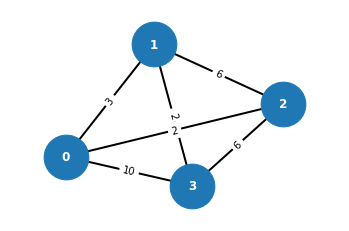

In [9]:
# n is the number of vertices in the graph G
n = 4
E = [(0, 1, 3), (0, 2, 2), (0, 3, 10), (1, 2, 6), (1, 3, 2), (2, 3, 6)]  # Parameters for edges: (vertex1, vertex2, weight(distance))
G = nx.Graph()
G.add_weighted_edges_from(E)

# Print out the generated graph G
pos = nx.spring_layout(G)
options = {
    "with_labels": True,
    "font_weight": "bold",
    "font_color": "white",
    "node_size": 2000,
    "width": 2
}
nx.draw_networkx(G, pos, **options)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=nx.get_edge_attributes(G,'weight'))
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

### Encoding Hamiltonian

In Paddle Quantum, a Hamiltonian can be input in the form of ``list``. Here we construct the Hamiltonian $H_C$ of Eq. (4) with the replacement in Eq. (5). It can be realized with a build-in function "tsp_hamiltonian(G, A, n)".

**Note:** For the salesman problem, the number of qubits can be reduced to $(n-1)^2$ since we can always select city $0$ to be the first city.

In [10]:
# Construct the Hamiltonian H_C in the form of list -- with build-in function tsp_hamiltonian(G, A, n)
A = 20 # Penalty parameter
H_C_list = tsp_hamiltonian(G, A, n)
# Generate the Hamiltonian
H_C = Hamiltonian(H_C_list)

### Calculating the loss function 

In the [Max-Cut tutorial](./MAXCUT_EN.ipynb), we use a circuit given by QAOA to find the ground state, but we can also use other circuits to solve combinatorial optimization problems. For the TSP, we adopt a parametrized quantum circuit constructed by $U_3(\vec{\theta})$ and $\text{CNOT}$ gates, which we call the [`complex entangled layer`](https://qml.baidu.com/api/paddle_quantum.circuit.uansatz.html).

<img src="./figures/tsp-fig-circuit.png" width="900px" /> 
<center> Figure 1: Parametrized Quantum Circuit used for TSM Problem </center>

After running the quantum circuit, we obtain the output state $|\psi(\vec{\theta})\rangle$. From the output state of the circuit we can calculate the objective function, and also the loss function of the TSP:

$$
L(\psi(\vec{\theta})) = \langle\psi(\vec{\theta})|H_C|\psi(\vec{\theta})\rangle.
\tag{7}
$$

We then use a classical optimization algorithm to minimize this function and find the optimal parameters $\vec{\theta}^*$. The following code shows a complete network built with Paddle Quantum and PaddlePaddle.

In [11]:
# In this tutorial we use build-in PQC: complex_entangled_layer()
def cir_TSP(N: int, DEPTH: int) -> Circuit:
    cir = Circuit(N)
    cir.complex_entangled_layer(depth=DEPTH)
    return cir

In [12]:
# Define the loss function
def loss_func(cir: Circuit, H: Hamiltonian) -> paddle.Tensor:
    state = cir()
    loss = paddle_quantum.loss.ExpecVal(H)
    return loss(state)

### Training the quantum neural network

After defining the quantum neural network, we use gradient descent method to update the parameters to minimize the expectation value in Eq. (7). 

In [13]:
DEPTH = 2   # Number of layers in the quantum circuit
ITR = 120   # Number of training iterations
LR = 0.5    # Learning rate of the optimization method based on gradient descent
SEED = 1000 # Set a global RNG seed 

Here, we optimize the network defined above in PaddlePaddle.

In [14]:
# Fix paddle random seed
paddle.seed(SEED)
# Record run time
time_start = time.time()

# Total qubits number: (city number-1)**2
num_qubits = (len(G) - 1) ** 2

# Create the circuit
cir = cir_TSP(num_qubits, DEPTH)

# Use Adam optimizer
opt = paddle.optimizer.Adam(learning_rate=LR, parameters=cir.parameters())

# Gradient descent iteration
for itr in range(1, ITR + 1):
    # Calculate the gradient and optimize
    loss = loss_func(cir, H_C)
    loss.backward()
    opt.minimize(loss)
    opt.clear_grad()
    if itr % 10 == 0:
        print("iter:", itr, " loss:", "%.4f"% loss.numpy(), "run time:", time.time()-time_start)
        
# The final minimum distance from QNN
print('The final minimum distance from QNN:', loss.numpy())

iter: 10  loss: 46.0240 run time: 2.0117030143737793
iter: 20  loss: 22.6653 run time: 3.6998016834259033
iter: 30  loss: 16.6194 run time: 5.470264673233032
iter: 40  loss: 14.3720 run time: 7.512751579284668
iter: 50  loss: 13.5547 run time: 9.417967319488525
iter: 60  loss: 13.1736 run time: 11.14768385887146
iter: 70  loss: 13.0661 run time: 13.029551029205322
iter: 80  loss: 13.0219 run time: 14.56725525856018
iter: 90  loss: 13.0035 run time: 16.211774110794067
iter: 100  loss: 13.0033 run time: 17.93900489807129
iter: 110  loss: 13.0008 run time: 19.850960731506348
iter: 120  loss: 13.0004 run time: 22.275184869766235
The final minimum distance from QNN: [13.000355]


Note that ideally the training network will find the shortest Hamiltonian cycle, and the final loss above would correspond to the total weights of the optimal cycle, i.e. the distance of the optimal path for the salesman. If not, then one should adjust parameters of the parameterized quantum circuits above for better training performance.

### Decoding the quantum solution

After obtaining the minimum value of the loss function and the corresponding set of parameters $\vec{\theta}^*$, our task has not been completed. In order to obtain an approximate solution to the TSP, it is necessary to decode the solution to the classical optimization problem from the quantum state $|\psi(\vec{\theta})^*\rangle$ output by the circuit. Physically, to decode a quantum state, we need to measure it and then calculate the probability distribution of the measurement results, where a measurement result is a bit string that represents an answer for the TSP: 

$$
p(z) = |\langle z|\psi(\vec{\theta})^*\rangle|^2.
\tag{8}
$$

Usually, the greater the probability of a certain bit string, the greater the probability that it corresponds to an optimal solution of the TSP.

Paddle Quantum provides a function to read the probability distribution of the measurement results of the state output by the quantum circuit:

In [15]:
# Repeat the simulated measurement of the circuit output state 1024 times
state = cir()
prob_measure = state.measure(shots=1024)
reduced_salesman_walk = max(prob_measure, key=prob_measure.get)
print("The reduced bit string form of the walk found:", reduced_salesman_walk)

The reduced bit string form of the walk found: 010001100


As we have slightly modified the TSP Hamiltonian to reduce the number of qubits used, the bit string found above has lost the information for our fixed vertex $n-1$ and the status of other vertices at time $n-1$. So we need to extend the found bit string to include these information.

We need to add a $0$ after every $(n-1)$ bits to represent $x_{i,n-1} = 0$ for $i \in [0, n-2]$. Then at last, we need to add the bit string representation for vertex $n-1$, i.e. '00...01' with $n-1$ 0s to represent $x_{n-1,t} = 0$ for all $t \in [0,n-2]$. 

After measurement, we have found the bit string with the highest probability of occurrence, the optimal walk in the form of the bit string. Each qubit contains the information of $x_{i,t}$ defined in Eq. (1). The following code maps the bit string back to the classic solution in the form of `dictionary`, where the `key` represents the vertex labeling and the `value` represents its order, i.e. when it is visited. 

Also, we have compared it with the solution found by the brute-force algorithm, to verify the correctness of the quantum algorithm.

In [16]:
# Optimal walk found by parameterized quantum circuit
str_by_vertex = [reduced_salesman_walk[i:i + n - 1] for i in range(0, len(reduced_salesman_walk) + 1, n - 1)]
salesman_walk = '0'.join(str_by_vertex) + '0' * (n - 1) + '1'
solution = {i:t for i in range(n) for t in range(n) if salesman_walk[i * n + t] == '1'}
distance = sum([G[u][v]["weight"] if solution[u] == (solution[v] + 1) % n 
                or solution[v] == (solution[u] + 1) % n else 0
                for (u, v) in G.edges])
print("The walk found by parameterized quantum circuit:", solution, "with distance", distance)

# Optimal walk found by brute-force algorithm for comparison
salesman_walk_brute_force, distance_brute_force = solve_tsp_brute_force(G)
solution_brute_force = {i:salesman_walk_brute_force.index(i) for i in range(n)}
print("The walk found by the brute-force algorithm:", solution_brute_force, "with distance", distance_brute_force)

The walk found by parameterized quantum circuit: {0: 1, 1: 2, 2: 0, 3: 3} with distance 13
The walk found by the brute-force algorithm: {0: 0, 1: 1, 2: 3, 3: 2} with distance 13


Here, we draw the corresponding optimal walk in the form of graph representation suggested to the salesman:
* The first number in the vertex represents the city number.
* The second number in the vertex represents the order the salesman visits the corresponding city.
* The red edges represent the found optimal route for the salesman.

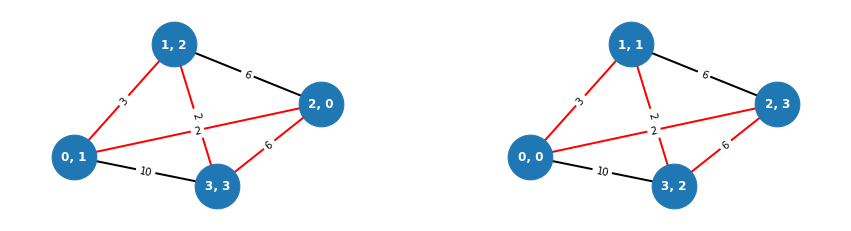

In [17]:
label_dict = {i: str(i) + ", " + str(t) for i, t in solution.items()}
edge_color = ["red" if solution[u] == (solution[v] + 1) % n
              or solution[v] == (solution[u] + 1) % n else "black"
              for (u, v) in G.edges]
label_dict_bf = {i: str(i) + ", " + str(t) for i, t in solution_brute_force.items()}
edge_color_bf = ["red" if solution_brute_force[u] == (solution_brute_force[v] + 1) % n
                 or solution_brute_force[v] == (solution_brute_force[u] + 1) % n else "black"
                 for (u, v) in G.edges]

# Draw the walk corresponding to the dictionary presented above on the graph
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i, a in enumerate(ax):
    a.axis('off')
    a.margins(0.20)
nx.draw(G, pos=pos, labels=label_dict, edge_color=edge_color, ax=ax[0], **options)
nx.drawing.nx_pylab.draw_networkx_edge_labels(G, pos=pos, ax=ax[0], edge_labels=nx.get_edge_attributes(G, 'weight'))
nx.draw(G, pos=pos, labels=label_dict_bf, edge_color=edge_color_bf, ax=ax[1], **options)
nx.drawing.nx_pylab.draw_networkx_edge_labels(G, pos=pos, ax=ax[1], edge_labels=nx.get_edge_attributes(G, 'weight'))
plt.axis("off")
plt.show()

The left graph given above shows a solution found by the parameterized quantum circuit, while the right graph given above shows a solution found by the brute-force algorithm. It can be seen that even if the order of the vertices are different, the routes are essentially the same, which verifies the correctness of using parameterized quantum circuit to solve the TSP.

##  Applications

The TSP naturally applies in many transportation and logistics applications, for example, the problem of arranging school bus routes. The school bus application provides the motivation for Merrill Flood, a pioneer in the field of management science, to study TSP research in the 1940s. More recent applications involve food delivery route management [1] and power delivery for cable firms [2]. 

Other than those transportation applications, TSP also has wide usefulness in other management problems like scheduling of a machine to drill holes in a circuit board [3], reconstructing an unknown fragment of DNA [4] and scheduling optimal route in construction management [5]. Some consulting companies like [Nexus](https://nexustech.com.ph/company/newsletter/article/Finding-the-shortest-path-Optimizing-food-trips) have utilized this to provide management service.

The TSP, as one of the most famous optimization problems, also provides a platform for the study of general methods in solving combinatorial problem. This is usually the first several problems that researchers give a try for experiments of new algorithms.

More applications, formulations and solution approaches can be found in [6].

_______

## References

[1] Bräysy, Olli, et al. "An optimization approach for communal home meal delivery service: A case study." [Journal of Computational and Applied Mathematics 232.1 (2009): 46-53.](https://www.sciencedirect.com/science/article/pii/S0377042708005438)

[2] Sloane, Thomas H., Frank Mann, and H. Kaveh. "Powering the last mile: an alternative to powering FITL." [Proceedings of Power and Energy Systems in Converging Markets. IEEE, 1997.](https://ieeexplore.ieee.org/document/646046)

[3] Onwubolu, Godfrey C. "Optimizing CNC drilling machine operations: traveling salesman problem-differential evolution approach." [New optimization techniques in engineering. Springer, Berlin, Heidelberg, 2004. 537-565.](https://link.springer.com/chapter/10.1007/978-3-540-39930-8_22)

[4] Caserta, Marco, and Stefan Voß. "A hybrid algorithm for the DNA sequencing problem." [Discrete Applied Mathematics 163 (2014): 87-99.](https://www.sciencedirect.com/science/article/pii/S0166218X12003253)

[5] Klanšek, Uroš. "Using the TSP solution for optimal route scheduling in construction management." [Organization, technology & management in construction: an international journal 3.1 (2011): 243-249.](https://www.semanticscholar.org/paper/Using-the-TSP-Solution-for-Optimal-Route-Scheduling-Klansek/3d809f185c03a8e776ac07473c76e9d77654c389)

[6] Matai, Rajesh, Surya Prakash Singh, and Murari Lal Mittal. "Traveling salesman problem: an overview of applications, formulations, and solution approaches." [Traveling salesman problem, theory and applications 1 (2010).](https://www.sciencedirect.com/topics/computer-science/traveling-salesman-problem)